# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [ ]:
from enum import Enum
from dataclasses import dataclass
from typing import Union
from PIL import Image, ImageDraw, ImageFont
import cv2 as cv
import numpy as np
import pytesseract
import zipfile

from IPython.display import display


def get_text_img(text):
    img = Image.new('RGB', (550, 34), '#FFF')
    fnt = ImageFont.truetype("readonly/fanwood-webfont.ttf", 38)
    draw = ImageDraw.Draw(img, mode='RGB')
    draw.text((0, 0), text, font=fnt, fill="#000")
    return img


no_faces_img = get_text_img('But there were no faces in that file!')


def get_text_from_img(img):
    return pytesseract.image_to_string(img).replace('\n',' ').replace('-','')


def get_contact_sheet_from_img(img):
    face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
    try:
        faces = (face_cascade.detectMultiScale(np.array(img), 1.35, 4)).tolist()
    except AttributeError:
        return no_faces_img
    faces_img_list = []
                
    for x,y,w,h in faces:
        faces_img_list.append(img.crop((x,y,x+w,y+h)))
    contact_sheet = Image.new(img.mode, (550, 110 * int(np.ceil(len(faces_img_list) / 5))))
    x = 0
    y = 0
    for face in faces_img_list:
        face.thumbnail((110, 110))
        contact_sheet.paste(face, (x, y))
        if x + 110 >= contact_sheet.width:
            x = 0
            y += 110
        else:
            x += 110
    return contact_sheet


@dataclass
class FileResults:
    file_name: str = None
    text: str = None
    img: Image.Image = None
    contact_sheet: Image.Image = None


class ArchiveType(Enum):
    """
    Archieve types, small or big.
    """
    SMALL = 1
    BIG = 2
        
    def __str__(self):
        return {
            ArchiveType.SMALL: './readonly/small_img.zip',
            ArchiveType.BIG: './readonly/images.zip'
        }[self]


# Global structure:
# {
#     ArchiveType:
#         [
#             FileResults()
#         ]
# }
class GlobalStruct:
    def __init__(self, *arch_types):
        self.main_struct = {arch_type: list() for arch_type in arch_types}
        
    def search(self, word, arch_type):
        if not self.main_struct.get(arch_type, None):
            self.__build_img_list_from_archive(arch_type)
        for f_result in self.main_struct.get(arch_type):
            if f_result.text.find(word) != -1:
                display(get_text_img(f"Results found in file {f_result.file_name}"))
                if not f_result.contact_sheet:
                    f_result.contact_sheet = get_contact_sheet_from_img(f_result.img)
                display(f_result.contact_sheet)

    def __str__(self):
        return str(self.main_struct)
    
    __repr__ = __str__
    
    def __build_img_list_from_archive(self, arch_file_type):
        archive = zipfile.ZipFile(str(arch_file_type), 'r')
        for zip_info_item in archive.infolist():
            file_result = FileResults()
            file_result.file_name = zip_info_item.filename
            img = Image.open(archive.open(file_result.file_name))
            file_result.img = img
            file_result.text = get_text_from_img(img)
            self.main_struct[arch_file_type].append(file_result)


# Create global structure
GLOBAL_STRUCT = GlobalStruct(*ArchiveType)

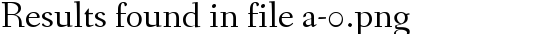

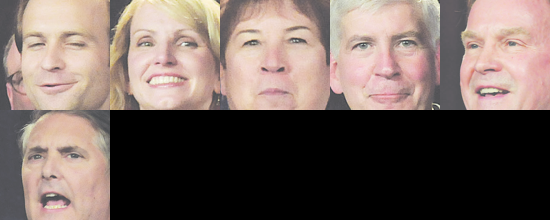

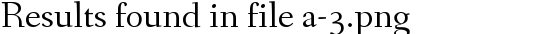

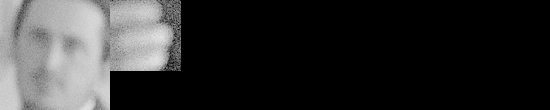

In [ ]:
GLOBAL_STRUCT.search("Christopher", ArchiveType.SMALL)

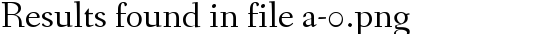

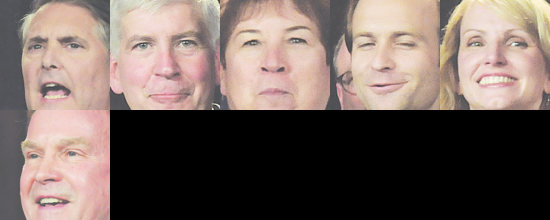

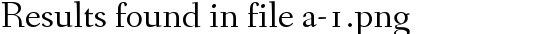

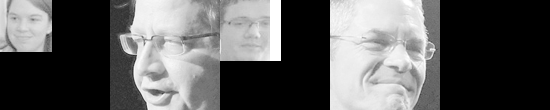

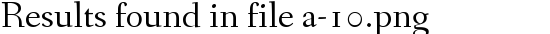

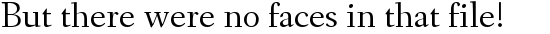

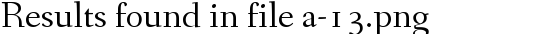

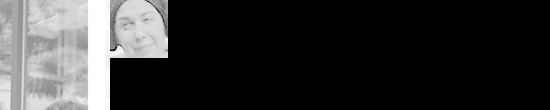

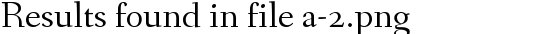

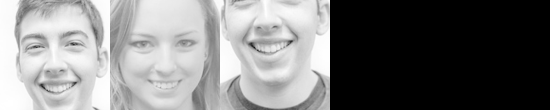

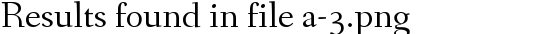

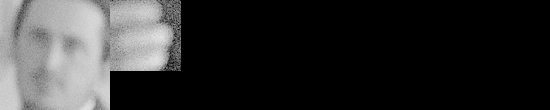

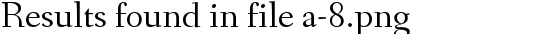

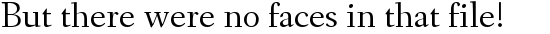

In [ ]:
GLOBAL_STRUCT.search("Mark", ArchiveType.BIG)